In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import LinearRegression
import sklearn
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
import xlrd
from tqdm.notebook import tqdm
import matplotlib
from mpl_toolkits import mplot3d
import pingouin as pg
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['tahoma']
def makeAxesPretty(ax):
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [2]:
expt_freq_seq = np.arange(90,3000,1) #array of possible true tones
expt_log_freq_seq_array = np.arange(np.log10(expt_freq_seq[0]), np.log10(expt_freq_seq[-1]), 
                                    np.log10(1003/1000)*40)
log_freq_seq_mid = np.median(expt_log_freq_seq_array)
log_freq_percept = np.arange(0.6,4.7,0.1)
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_low = [log_freq_seq_mid - 0.15,0.1]  #low freq condition is gaussian 
log_freq_high = [log_freq_seq_mid + 0.15,0.1] 

def extractData(csv_test, csv_data, exptTotalLength, exptLengthWithBreaks):  
    n_tones=3
    n_trials = csv_data.shape[0]-47

    test_columns = list(csv_test.columns)
    test_tones_name = test_columns.index('Name')
    test_tones_col_idx = test_columns.index('Tones')
    test_toneKind_col_idx = test_columns.index('Tonekind')
    df_names = (csv_test.iloc[0:exptTotalLength,test_tones_name]).values
    df_tones = (csv_test.iloc[0:exptTotalLength,test_tones_col_idx]).values
    df_toneKind = (csv_test.iloc[0:exptTotalLength,test_toneKind_col_idx]).values

    tones_array_orig = np.zeros((n_trials,n_tones))
    toneKind_array_orig = np.zeros((n_trials,n_tones))
    tones_array_idxs_keep = []

    for i_wav in range(exptLengthWithBreaks):
        if isinstance(csv_data['Name'][i_wav+46],str):
            tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]\
                                                              ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            toneKind_array_orig[i_wav,:] = np.array(df_toneKind[np.where(csv_data['Name'][i_wav+46]\
                                                              ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            tones_array_idxs_keep += [i_wav]


    exptTones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
    exptToneKind = np.copy(toneKind_array_orig[tones_array_idxs_keep,:])
    exptCorrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    exptKeys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    
    return exptTones, exptToneKind, exptCorrans, exptKeys

def identifyResponseTrials(tonesPlayed,tonesSignalOrDistractor,correctAns,keysPressed,
                           exptTotalLength):
    no_response = np.intersect1d(np.where(keysPressed!='h')[0],
                                 np.where(keysPressed!='l')[0])
    #print("Did not respond to: ",no_response)

    """
    Convert keys ['l','h'] to [0,1]
    """

    corrans_num_orig = np.zeros_like(correctAns)
    corrans_num_orig[correctAns == 'h'] = 1

    keys_num_orig = np.zeros_like(keysPressed)
    keys_num_orig[keysPressed == 'h'] = 1

    corrans_num = corrans_num_orig[:exptTotalLength]
    keys_num = keys_num_orig[:exptTotalLength]
    tones_array = tonesPlayed[:exptTotalLength]
    tonesType_array = tonesSignalOrDistractor[:exptTotalLength]

    trial_tones = np.repeat(tones_array,1,axis = 0)
    trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
    idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
    trialTonesResponded = trial_tones[idxs_with_response,:]
    trialBehaviourResponded = trial_behaviour[idxs_with_response]
    corransResponded = corrans_num[idxs_with_response]
    tonesTypeResponded = tonesType_array[idxs_with_response]
    
    return trialTonesResponded, tonesTypeResponded, corransResponded, trialBehaviourResponded 

def plottingInfluenceFn(tones, behaviour):
    unique_tones = np.unique(tones)

    tone1_prob_behaviour = np.zeros((len(unique_tones),1))
    tone2_prob_behaviour = np.zeros((len(unique_tones),1))
    tone3_prob_behaviour = np.zeros((len(unique_tones),1))

    for i_tone in range(len(unique_tones)):
        tone1_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,0]==unique_tones[i_tone]])
        tone2_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,1]==unique_tones[i_tone]])
        tone3_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,2]==unique_tones[i_tone]])
    behaviour = np.concatenate((tone1_prob_behaviour,tone2_prob_behaviour,tone3_prob_behaviour),axis=1)
    return unique_tones, behaviour    


In [3]:
"""
Subsample the long context expt with a low category bias
"""
def subsample(trial_behaviour_full, corrans_full, trial_tones_full, ifLowCategory):
    idxHigh = np.arange(len(trial_behaviour_full[0:]))[corrans_full[0:]==1]
    idxLow = np.arange(len(trial_behaviour_full[0:]))[corrans_full[0:]==0]
    if ifLowCategory:
        idxOfSmallerCategory = np.random.choice(idxLow,size=len(idxHigh),replace=False)
        idxToKeep = np.concatenate((idxHigh, idxOfSmallerCategory))
    else:
        idxOfSmallerCategory = np.random.choice(idxHigh,size=len(idxLow),replace=False)
        idxToKeep = np.concatenate((idxLow, idxOfSmallerCategory))
    return idxToKeep
    
def subsampleLongContextLow(toneslc,toneTypeslc,corranslc,keyslc):
    [trial_tones_fulllc, trial_tonesType_fulllc, 
    corrans_fulllc, trial_behaviour_fulllc] = identifyResponseTrials(keysPressed = keyslc, 
                                                                     correctAns = corranslc, 
                                                                     tonesPlayed = toneslc, 
                                                                     tonesSignalOrDistractor=toneTypeslc,
                                                                     exptTotalLength = 800)
    corrAns_firstHalfLC = corrans_fulllc[:len(corrans_fulllc)//2]
    corrAns_secondHalfLC = corrans_fulllc[len(corrans_fulllc)//2:]
    trialBehaviour_firstHalfLC = trial_behaviour_fulllc[:len(trial_behaviour_fulllc)//2]
    trialBehaviour_secondHalfLC = trial_behaviour_fulllc[len(trial_behaviour_fulllc)//2:]
    trialTones_firstHalfLC = trial_tones_fulllc[:len(trial_tones_fulllc)//2,:]
    trialTones_secondHalfLC = trial_tones_fulllc[len(trial_tones_fulllc)//2:,:]
    
    idxToKeep = subsample(trialBehaviour_firstHalfLC, corrAns_firstHalfLC, trialTones_firstHalfLC, 1)
    
    trialTonesSubsampled_firstHalfLC = trialTones_firstHalfLC[idxToKeep,:]
    trialBehaviourSubsampled_firstHalfLC = trialBehaviour_firstHalfLC[idxToKeep]
    corrAnsSubsampled_firstHalfLC = corrAns_firstHalfLC[idxToKeep]
    
    idxToKeep = subsample(trialBehaviour_secondHalfLC, corrAns_secondHalfLC, trialTones_secondHalfLC, 1)
    
    trialTonesSubsampled_secondHalfLC = trialTones_secondHalfLC[idxToKeep,:]
    trialBehaviourSubsampled_secondHalfLC = trialBehaviour_secondHalfLC[idxToKeep]
    corrAnsSubsampled_secondHalfLC = corrAns_secondHalfLC[idxToKeep]
    
    #print("Got correct: ", np.sum(trial_behaviour_exptlc==corrans_exptlc)/len(trial_tones_exptlc))
    return [trialTonesSubsampled_firstHalfLC, trialBehaviourSubsampled_firstHalfLC,
            trialTonesSubsampled_secondHalfLC, trialBehaviourSubsampled_secondHalfLC]

"""
Subsample the long context expt with a high category bias
"""
def subsampleLongContextHigh(toneshc,toneTypeshc,corranshc,keyshc):
    [trial_tones_fullhc, trial_tonesType_fullhc, 
     corrans_fullhc, trial_behaviour_fullhc] = identifyResponseTrials(keysPressed = keyshc, 
                                                                      correctAns = corranshc,
                                                                      tonesPlayed = toneshc,
                                                                      tonesSignalOrDistractor=toneTypeshc,
                                                                      exptTotalLength = 800)
    corrAns_firstHalfHC = corrans_fullhc[:len(corrans_fullhc)//2]
    corrAns_secondHalfHC = corrans_fullhc[len(corrans_fullhc)//2:]
    trialBehaviour_firstHalfHC = trial_behaviour_fullhc[:len(trial_behaviour_fullhc)//2]
    trialBehaviour_secondHalfHC = trial_behaviour_fullhc[len(trial_behaviour_fullhc)//2:]
    trialTones_firstHalfHC = trial_tones_fullhc[:len(trial_tones_fullhc)//2,:]
    trialTones_secondHalfHC = trial_tones_fullhc[len(trial_tones_fullhc)//2:,:]
    
    idxToKeep = subsample(trialBehaviour_firstHalfHC, corrAns_firstHalfHC, trialTones_firstHalfHC, 0)
    
    trialTonesSubsampled_firstHalfHC = trialTones_firstHalfHC[idxToKeep,:]
    trialBehaviourSubsampled_firstHalfHC = trialBehaviour_firstHalfHC[idxToKeep]
    corrAnsSubsampled_firstHalfHC = corrAns_firstHalfHC[idxToKeep]
    
    idxToKeep = subsample(trialBehaviour_secondHalfHC, corrAns_secondHalfHC, trialTones_secondHalfHC, 0)
    
    trialTonesSubsampled_secondHalfHC = trialTones_secondHalfHC[idxToKeep,:]
    trialBehaviourSubsampled_secondHalfHC = trialBehaviour_secondHalfHC[idxToKeep]
    corrAnsSubsampled_secondHalfHC = corrAns_secondHalfHC[idxToKeep]
    
    #print("Got correct: ", np.sum(trial_behaviour_exptlc==corrans_exptlc)/len(trial_tones_exptlc))
    return [trialTonesSubsampled_firstHalfHC, trialBehaviourSubsampled_firstHalfHC,
            trialTonesSubsampled_secondHalfHC, trialBehaviourSubsampled_secondHalfHC]


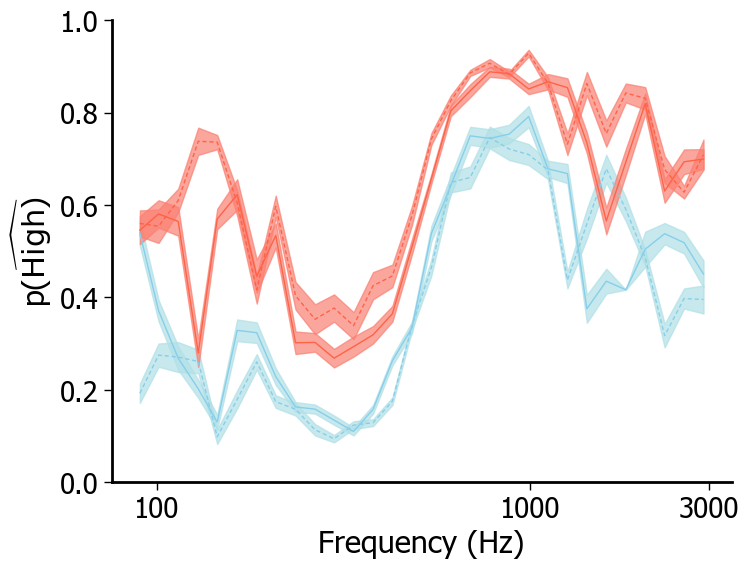

In [6]:
"""
Qs: How does fitting look like across all subjects in the biased experiment?
"""

averageSubjectBehaviourLC_FirstHalf = np.empty(shape=(53,30))
averageSubjectBehaviourLC_SecondHalf = np.empty(shape=(53,30))
averageSubjectBehaviourHC_FirstHalf = np.empty(shape=(48,30))
averageSubjectBehaviourHC_SecondHalf = np.empty(shape=(48,30))
numberOfSubsamples=1

Test = pd.read_csv('subjectDataForPlots/allTrials_lowContext.csv')
SubjectFiles = os.listdir('subjectDataForPlots/biasedLowContextData')

for subjectIdx in range(53):  
    filename = 'subjectDataForPlots/biasedLowContextData/'+SubjectFiles[subjectIdx]  
    Data = pd.read_csv(filename);
    subjectBehaviourLC_FirstHalf = np.empty((numberOfSubsamples,30))   
    subjectBehaviourLC_SecondHalf = np.empty((numberOfSubsamples,30))  
    df_tones, df_toneKind, df_corrans, df_keys = extractData(csv_test=Test, 
                                                             csv_data=Data, 
                                                             exptTotalLength=800,
                                                             exptLengthWithBreaks=804) 
    uniqueTones = np.unique(df_tones)

    for iSubsample in range(numberOfSubsamples):
        [sampledTonesLC_FirstHalf, sampledBehaviourLC_FirstHalf,
        sampledTonesLC_SecondHalf, sampledBehaviourLC_SecondHalf] = subsampleLongContextLow(toneslc=df_tones,
                                                                                            toneTypeslc=df_toneKind,
                                                                                            corranslc=df_corrans,
                                                                                            keyslc=df_keys) 

        unique_tones_played, allSubjectBehaviourLC_FirstHalf = plottingInfluenceFn(sampledTonesLC_FirstHalf, 
                                                                                  sampledBehaviourLC_FirstHalf) 
        subjectBehaviourLC_FirstHalf[iSubsample,
                                     np.where(np.in1d(uniqueTones, 
                                                      unique_tones_played))[0]] = np.mean(allSubjectBehaviourLC_FirstHalf,axis=1)

        unique_tones_played, allSubjectBehaviourLC_SecondHalf = plottingInfluenceFn(sampledTonesLC_SecondHalf,
                                                                                    sampledBehaviourLC_SecondHalf)  
        subjectBehaviourLC_SecondHalf[iSubsample,
                                      np.where(np.in1d(uniqueTones, 
                                                      unique_tones_played))[0]] = np.mean(allSubjectBehaviourLC_SecondHalf,axis=1)
            
    averageSubjectBehaviourLC_FirstHalf[subjectIdx,:] = np.nanmean(subjectBehaviourLC_FirstHalf,axis=0)
    averageSubjectBehaviourLC_SecondHalf[subjectIdx,:] = np.nanmean(subjectBehaviourLC_SecondHalf,axis=0)
    
    
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.log10(unique_tones_played), np.nanmean(averageSubjectBehaviourLC_FirstHalf,axis=0),
        color='skyblue',linewidth=1)
ax.fill_between(np.log10(unique_tones_played),
                y1 = np.nanmean(averageSubjectBehaviourLC_FirstHalf,axis=0) - 
                np.nanstd(averageSubjectBehaviourLC_FirstHalf,axis=0)/np.sqrt(53),
                y2 = np.nanmean(averageSubjectBehaviourLC_FirstHalf,axis=0) + 
                np.nanstd(averageSubjectBehaviourLC_FirstHalf,axis=0)/np.sqrt(53),
                color='powderblue',alpha=0.7)

ax.plot(np.log10(unique_tones_played), np.nanmean(averageSubjectBehaviourLC_SecondHalf,axis=0),
        color='skyblue', linestyle='dashed', linewidth=1, dashes=(3, 2))
ax.fill_between(np.log10(unique_tones_played),
                y1 = np.nanmean(averageSubjectBehaviourLC_SecondHalf,axis=0) - 
                np.nanstd(averageSubjectBehaviourLC_SecondHalf,axis=0)/np.sqrt(53),
                y2 = np.nanmean(averageSubjectBehaviourLC_SecondHalf,axis=0) + 
                np.nanstd(averageSubjectBehaviourLC_SecondHalf,axis=0)/np.sqrt(53),
                color='powderblue',alpha=0.7)


Test = pd.read_csv('subjectDataForPlots/allTrials_highContext.csv')
SubjectFiles = os.listdir('subjectDataForPlots/biasedHighContextData')
for subjectIdx in range(48): 
    filename = 'subjectDataForPlots/biasedHighContextData/'+SubjectFiles[subjectIdx] 
    Data = pd.read_csv(filename);
    subjectBehaviourHC_FirstHalf = np.empty((numberOfSubsamples,30))   
    subjectBehaviourHC_SecondHalf = np.empty((numberOfSubsamples,30))  
    df_tones, df_toneKind, df_corrans, df_keys = extractData(csv_test=Test, 
                                                             csv_data=Data, 
                                                             exptTotalLength=800,
                                                             exptLengthWithBreaks=804) 
    uniqueTones = np.unique(df_tones)

    for iSubsample in range(numberOfSubsamples):
        [sampledTonesHC_FirstHalf, sampledBehaviourHC_FirstHalf,
        sampledTonesHC_SecondHalf, sampledBehaviourHC_SecondHalf] = subsampleLongContextHigh(toneshc=df_tones,
                                                                                            toneTypeshc=df_toneKind,
                                                                                            corranshc=df_corrans,
                                                                                            keyshc=df_keys) 

        unique_tones_played, allSubjectBehaviourHC_FirstHalf = plottingInfluenceFn(sampledTonesHC_FirstHalf,
                                                                                   sampledBehaviourHC_FirstHalf) 
        subjectBehaviourHC_FirstHalf[iSubsample,
                                     np.where(np.in1d(uniqueTones, 
                                                      unique_tones_played))[0]] = np.mean(allSubjectBehaviourHC_FirstHalf,axis=1)

        unique_tones_played, allSubjectBehaviourHC_SecondHalf = plottingInfluenceFn(sampledTonesHC_SecondHalf,
                                                                                    sampledBehaviourHC_SecondHalf)  
        subjectBehaviourHC_SecondHalf[iSubsample,
                                      np.where(np.in1d(uniqueTones, 
                                                      unique_tones_played))[0]] = np.mean(allSubjectBehaviourHC_SecondHalf,axis=1)
            
    averageSubjectBehaviourHC_FirstHalf[subjectIdx,:] = np.nanmean(subjectBehaviourHC_FirstHalf,axis=0)
    averageSubjectBehaviourHC_SecondHalf[subjectIdx,:] = np.nanmean(subjectBehaviourHC_SecondHalf,axis=0)
    
ax.plot(np.log10(unique_tones_played), np.nanmean(averageSubjectBehaviourHC_FirstHalf,axis=0),
        color='tomato',linewidth=1)
ax.fill_between(np.log10(unique_tones_played),
                y1 = np.nanmean(averageSubjectBehaviourHC_FirstHalf,axis=0) - 
                np.nanstd(averageSubjectBehaviourHC_FirstHalf,axis=0)/np.sqrt(48),
                y2 = np.nanmean(averageSubjectBehaviourHC_FirstHalf,axis=0) + 
                np.nanstd(averageSubjectBehaviourHC_FirstHalf,axis=0)/np.sqrt(48),
                color='salmon',alpha=0.7)

ax.plot(np.log10(unique_tones_played), np.nanmean(averageSubjectBehaviourHC_SecondHalf,axis=0),
        color='tomato', linestyle='dashed', linewidth=1, dashes=(3, 2))
ax.fill_between(np.log10(unique_tones_played),
                y1 = np.nanmean(averageSubjectBehaviourHC_SecondHalf,axis=0) - 
                np.nanstd(averageSubjectBehaviourHC_SecondHalf,axis=0)/np.sqrt(48),
                y2 = np.nanmean(averageSubjectBehaviourHC_SecondHalf,axis=0) + 
                np.nanstd(averageSubjectBehaviourHC_SecondHalf,axis=0)/np.sqrt(48),
                color='salmon',alpha=0.7)

ax.set_xticks(ticks=np.log10([100,1000,3000]))
ax.set_xticklabels(labels=[100,1000,3000])
ax.set_yticks(ticks=np.arange(0,1.1,0.2))
ax.set_yticklabels(labels=np.around(np.arange(0,1.1,0.2),1))
ax.tick_params(axis='both',labelsize=20,length=6,width=1)
ax.set_xlabel('Frequency (Hz)',fontsize=22)
ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=22)
makeAxesPretty(ax)

fig.savefig('figures/FromProlific/illustrations/AverageSubject_EffectOfBlockHalf_BiasedSessions.pdf',
             bbox_inches='tight',transparent=True)



In [ ]:
"""
Stats for delta parameter for correctness. Delta quantifies the effect of the previous trial.
"""

print("Long-term learning in low context temporal effect")
print(np.mean(averageSubjectBehaviourLC_FirstHalf[:,13:17],axis=1) - 
      np.mean(averageSubjectBehaviourLC_SecondHalf[:,13:17],axis=1),
      np.mean(np.mean(averageSubjectBehaviourLC_FirstHalf[:,13:17],axis=1) - 
              np.mean(averageSubjectBehaviourLC_SecondHalf[:,13:17],axis=1)))

print("Long-term learning in high context temporal effect")
print(np.mean(averageSubjectBehaviourHC_FirstHalf[:,13:17],axis=1) - 
      np.mean(averageSubjectBehaviourHC_SecondHalf[:,13:17],axis=1),
      np.mean(np.mean(averageSubjectBehaviourHC_FirstHalf[:,13:17],axis=1) - 
              np.mean(averageSubjectBehaviourHC_SecondHalf[:,13:17],axis=1)))

print("Wilcoxon test on short-term learning delta",
      pg.wilcoxon(np.mean(averageSubjectBehaviourLC_FirstHalf[:,13:17],axis=1) -
                  np.mean(averageSubjectBehaviourLC_SecondHalf[:,13:17],axis=1)),
      pg.wilcoxon(np.mean(averageSubjectBehaviourHC_FirstHalf[:,13:17],axis=1) -
                  np.mean(averageSubjectBehaviourHC_SecondHalf[:,13:17],axis=1)))

longTermLearning_dict = {"behaviourFirstHalfLC": averageSubjectBehaviourLC_FirstHalf,
                         "behaviourSecondHalfLC": averageSubjectBehaviourLC_SecondHalf,
                         "behaviourFirstHalfHC": averageSubjectBehaviourHC_FirstHalf,
                         "behaviourSecondHalfHC": averageSubjectBehaviourHC_SecondHalf}

#scipy.io.savemat("longTermLearning_temporalEffect.mat", longTermLearning_dict)